In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

import razdel
from pymystem3 import Mystem
m = Mystem()

In [2]:
data_train = pd.read_csv('train.csv')

In [3]:
data_train.shape

(112467, 3)

In [4]:
data_train.head(5)

,id,text,label
0,0,ж 44 позн с мужч от 40 лет 0678935919,1
1,1,уже и не вспомню где это увидел,2
2,2,", sep=';', decimal=',' может изза этого",2
3,3,НУЖНА ДЕВ ДЛЯ С\\О -19л.0637048428смс,1
4,4,.М54.ИЩУ Д.Ж. С-П.ДЛЯ ЛАСК...НЕКМ.0508665030....,1


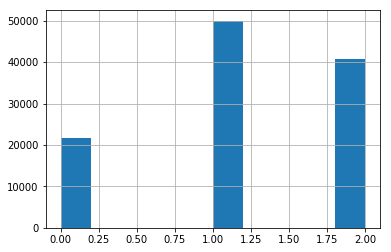

In [5]:
data_train.label.hist()
plt.show()

In [6]:
def tokenize_with_razdel(text):
    return [token.text for token in razdel.tokenize(''.join(m.lemmatize( text)))]

from pymystem3 import Mystem
m = Mystem()
def lemmatize_with_mystem(tokens):
    return tokenize_with_razdel(( ''.join(m.lemmatize( tokens)) ))

In [7]:
data_t = np.array([x.lower() for x in data_train.text])
ltrain = np.array(data_train.label)

In [8]:
def find_best_param(text, label):
    '''Function chooses parameters.'''
    best_tfidf = None
    best_model = None
    best_min = None
    best_ngram = None
    best_C = None
    global_best_score = 0
    

    for min_df in range(1, 4):
        for n_gram in range(1,4):
            tfidf = TfidfVectorizer(min_df=min_df, ngram_range=(1,n_gram), tokenizer=lemmatize_with_mystem)
            data_transform = tfidf.fit_transform(text)
            best_score = 0
            for c in np.arange(0.1, 2.0, 0.1):
                model =  LinearSVC(C=c)
                score = cross_val_score(model, data_transform, label, cv=3, scoring='f1_micro').mean()
                if(score > best_score):
                    best_score = score
                if(score > global_best_score):
                    global_best_score = score
                    best_tfidf = tfidf
                    best_model = model
                    best_min = min_df
                    best_ngram = n_gram
                    best_C = c
            print(f'min_df = {min_df}, n_gram = {n_gram}, score = {best_score}')  
    return [best_min, best_ngram, best_C]

In [9]:
best_param = find_best_param(data_t, ltrain)

min_df = 1, n_gram = 1, score = 0.8943690060854607
min_df = 1, n_gram = 2, score = 0.8914615038588699
min_df = 1, n_gram = 3, score = 0.8898076671422537
min_df = 2, n_gram = 1, score = 0.894973631680768
min_df = 2, n_gram = 2, score = 0.8924039961442695
min_df = 2, n_gram = 3, score = 0.8922528288353678
min_df = 3, n_gram = 1, score = 0.8943067746186367
min_df = 3, n_gram = 2, score = 0.8914348182206279
min_df = 3, n_gram = 3, score = 0.8914259234031888


In [14]:
#Prediction

data_test = pd.read_csv('test.csv')

model = LinearSVC(C = best_param[2])
tfidf = TfidfVectorizer(min_df=best_param[0], ngram_range=(1,best_param[1]), tokenizer=lemmatize_with_mystem)

data_train_transform = tfidf.fit_transform(data_t)
model.fit(data_train_transform, ltrain)

data_test_transform = tfidf.transform([x.lower() for x in data_test.text])
data_test['label'] = model.predict(data_test_transform)


data_test[['id', 'label']].to_csv('predict3.csv', index=False)